In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as ss
import scipy.optimize as so
import tqdm

In [2]:
mpl.rcParams['figure.dpi'] *= 2

In [3]:
rng = np.random.default_rng()

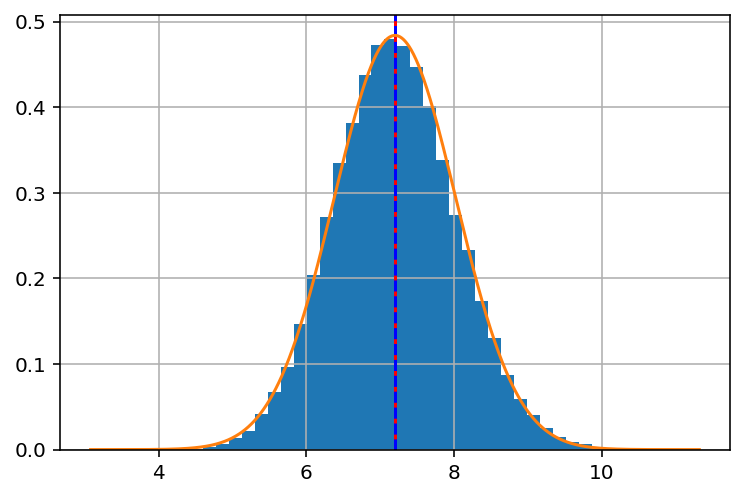

In [4]:

# means
R0 = 160/100 # TES resistance (mOhm)
b0 = 2.5 # beta

# std devs
dR = R0/10
db = b0/10

# typical ranges
Rm_space = dR*np.linspace(-5, 5, 1000) + R0
bm_space = db*np.linspace(-5, 5, 1000) + b0

def R(N = 100):
    return rng.normal(loc = R0, scale = dR, size = N)

def b(N = 100):
    return rng.normal(loc = b0, scale = db, size = N)

def normal(x, mu, sig):
    return np.exp(-(x-mu)**2/2/sig**2)/np.sqrt(2*np.pi)/sig

def Rnormal(x):
    return normal(x, R0, dR)
def bnormal(x):
    return normal(x, b0, db)


N = 100_000
Rbs = R(N)*(2+b(N))

# combined params
Rb0 = R0*(2 + b0)
dRb = np.sqrt(dR**2*db**2 + dR**2*(2+b0)**2 + db**2*R0**2)

xs = dRb*np.linspace(-5, 5, 1000) + Rb0

Rb_dist= normal(xs, Rb0, dRb)

plt.figure()
plt.grid()
plt.hist(Rbs, density = True, bins = 40)
plt.axvline(Rb0, color = 'r')
plt.axvline(Rbs.mean(), color = 'b', linestyle = '--')
plt.plot(xs, Rb_dist)

In [5]:

def show_approx(R0 = 2.5, b0 = 0.5, rel_dR = 0.1, rel_db = 0.1):
    # means
    #R0 = TES resistance (mOhm)
    #b0 = beta


    dR = R0*rel_dR
    db = b0*rel_db

    # typical ranges
    #Rm_space = dR*np.linspace(-5, 5, 1000) + R0
    #bm_space = db*np.linspace(-5, 5, 1000) + b0

    def R(N = 100):
        return rng.normal(loc = R0, scale = dR, size = N)

    def b(N = 100):
        return rng.normal(loc = b0, scale = db, size = N)

    N = 1000_000
    Rbs = R(N)*(2+b(N))

    # combined params
    Rb0 = R0*(2 + b0)
    dRb = np.sqrt(dR**2*db**2 + dR**2*(2+b0)**2 + db**2*R0**2)

    xs = dRb*np.linspace(-5, 5, 1000) + Rb0

    Rb_dist= normal(xs, Rb0, dRb)

    plt.figure()
    plt.title(f'$\\beta = {b0}$, $\\Delta\\beta/\\beta = ${rel_db*100:.0f}%')
    plt.grid()
    plt.hist(Rbs, density = True, bins = 100, label = f'simulation\n({N:.0g} samples)')
    plt.axvline(Rb0, color = 'r', label = 'predicted mean')
    plt.axvline(Rbs.mean(), color = 'b', linestyle = '--', label = 'sample mean')
    plt.plot(xs, Rb_dist, label = 'gaussian approx')
    plt.legend()
    plt.xlabel('$R_m(2+\\beta_m)$')

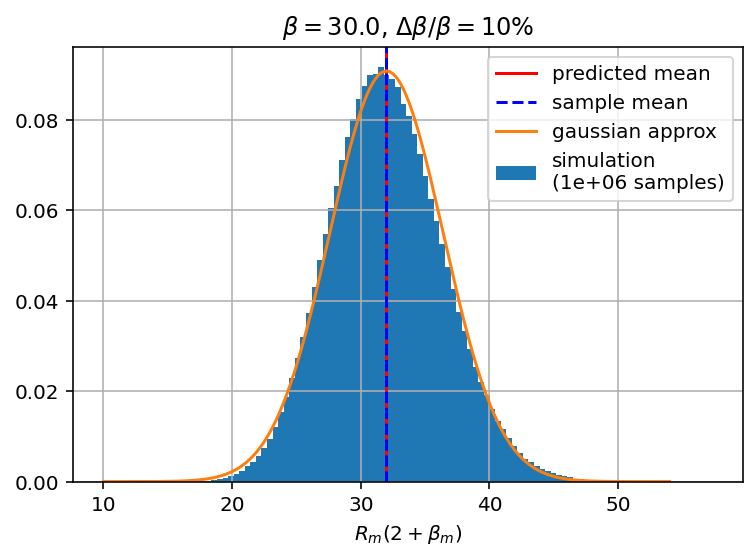

In [6]:
show_approx(R0 = 1, b0 = 30., rel_db = 0.1)

In [7]:

def show_dist(R0 = 2.5, b0 = 0.5, rel_dR = 0.1, rel_db = 0.1, M = 100, dv = 0.01):
    # means
    #R0 = TES resistance (mOhm)
    #b0 = beta

    vm = rng.normal(loc = 1, scale = dv, size = (M,1))
    #vm = 2*rng.random(size = (M,1))

    #vm = rng.choice((-1,1), size = (M,1))*rng.normal(loc = dv, scale = 0.1*dv, size = (M,1))

    #vm /= vm.mean()


    dR = R0*rel_dR
    db = b0*rel_db

    # typical ranges
    #Rm_space = dR*np.linspace(-5, 5, 1000) + R0
    #bm_space = db*np.linspace(-5, 5, 1000) + b0

    def R(N = 100):
        return rng.normal(loc = R0, scale = dR, size = (M,N))

    def b(N = 100):
        return rng.normal(loc = b0, scale = db, size = (M,N))

    N = 1000_000
    Rbs = (vm*R(N)*(2+b(N))).sum(axis = 0)/vm.sum()

    # combined params
    Rb0 = R0*(2 + b0)
    D2 = dR**2*db**2 + dR**2*(2+b0)**2 + db**2*R0**2

    var = (1 + dv**2)*D2/M

    xs = np.sqrt(var)*np.linspace(-5, 5, 1000) + Rb0

    Rb_dist = normal(xs, Rb0, np.sqrt(var))
    Rb_dist2 = normal(xs, Rb0, np.sqrt(D2/M))

    plt.figure()
    plt.title(f'$\\beta = {b0}$, $\\Delta\\beta/\\beta = ${rel_db*100:.0f}%, $\\delta v = ${dv*100:.0f}%')
    plt.grid()
    plt.hist(Rbs, density = True, bins = 100, label = f'simulation\n({N:.0g} samples)')
    plt.axvline(Rb0, color = 'r', label = 'predicted mean')
    plt.axvline(Rbs.mean(), color = 'b', linestyle = '--', label = 'sample mean')
    plt.plot(xs, Rb_dist, label = 'gaussian approx')
    plt.plot(xs, Rb_dist2, label = 'approx w/ zero dv')
    plt.legend()
    plt.xlabel('$\sum_mv_mR_m(2+\\beta_m)/\\sum_mv_m$')

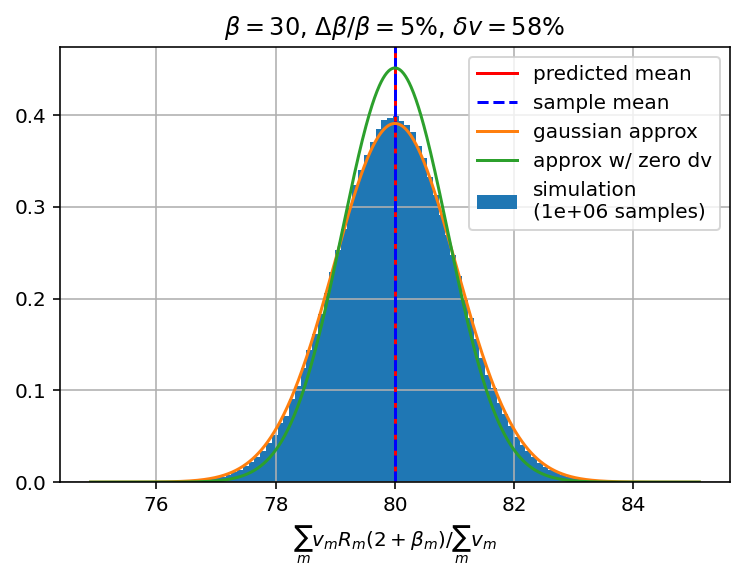

In [8]:
show_dist(b0 = 30, rel_db = 0.05, dv = np.sqrt(1/3))

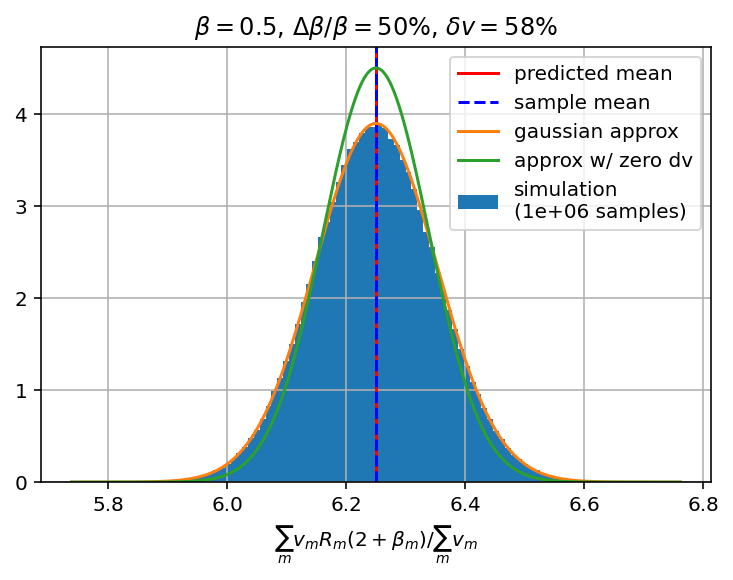

In [9]:
show_dist(b0 = 0.5, rel_db = 0.5, dv = np.sqrt(1/3))# 0.5

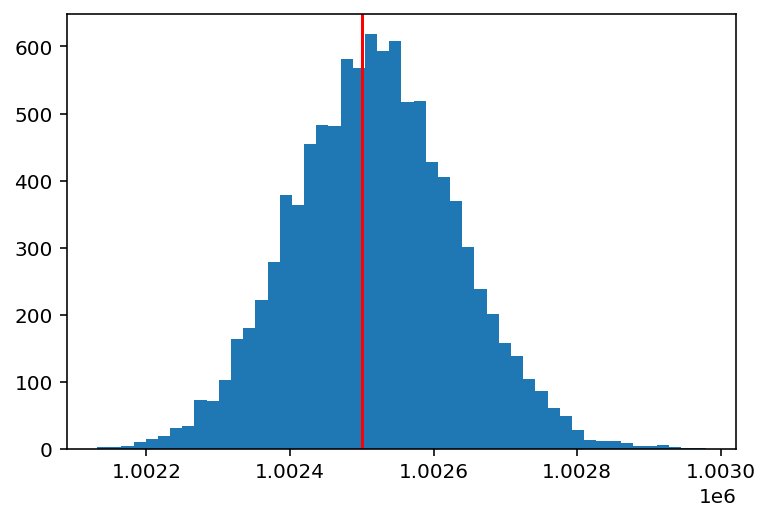

In [10]:
def get_thing(M = 10_000, dv = 0.01):

    #vm = rng.choice((-1,1), size = M)*rng.random(size = M)
    #vm = rng.choice((-1,1), size = M)*(rng.standard_normal(size = M)+1)
    vm = rng.normal(loc = 1, scale = dv, size = M)
    #vm = rng.random(size = M)

    return (1/vm).sum(axis = 0)*vm.sum(axis = 0)


M = 1000
trials = 10_000
dv = 0.05

plt.hist(get_thing((M, trials), dv = dv), bins = 50)
#plt.loglog()
plt.axvline(M**2*(1 + dv**2), color = 'r')

In [11]:
get_thing((M, trials), dv = dv).size # should be 10_000 (= trials)

10000

In [502]:
def complex_histogram(data, bins = 40, **kwargs):
    fig, axs = plt.subplots(nrows = 1, ncols = 2, **kwargs)

    axs[0].hist(np.real(data), bins = bins, histtype = 'step')
    axs[1].hist(np.imag(data), bins = bins, histtype = 'step')
    axs[0].set_title('Re(z)')
    axs[1].set_title('Im(z)')

    return fig, axs

def plot_traces(*traces, ls = '-', x = None, labels = None, **kwargs):
    fig, axs = plt.subplots(nrows = 1, ncols = 2, **kwargs)
    if x is None:
        x = np.arange(len(traces[0]))

    if labels:
        for trace, label in zip(traces, labels):
            axs[0].plot(x, np.real(trace), ls, label = label)
            axs[1].plot(x, np.imag(trace), ls, label = label)

    axs[0].set_title('Real part')
    axs[1].set_title('Imag part')

    return fig, axs


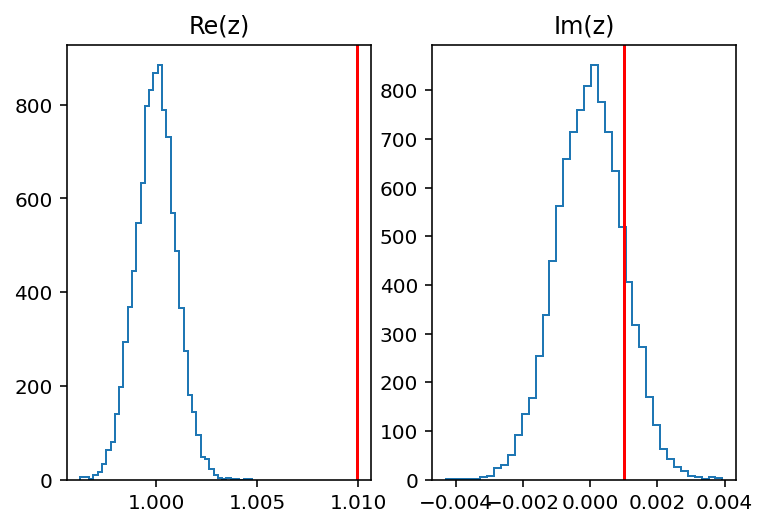

In [13]:
def get_complex_thing(M = 100, ntrials = 10_000, vr = 10, vi = 0.01, dv = 0.01):

    vr = 10
    vi = 0.1
    nn = 10_000

    vbar = vr + 1j*vi

    sigv = abs(vbar)*dv

    vm = vbar + rng.normal(loc = 0, scale = sigv/np.sqrt(2), size = (M,ntrials)) + 1j*rng.normal(loc = 0, scale = sigv/np.sqrt(2), size = (M,ntrials))

    return (1/vm).sum(axis = 0)*vm.sum(axis = 0)

vr = 10
vi = 1
vbar = vr + 1j*vi
M = 100
ntrials = 10_000
dv = 0.1
varv = (dv)**2*vbar/abs(vbar)

vmsums = get_complex_thing(M = M, ntrials = ntrials, vr = vr, vi = vi, dv = dv)/M**2

fig, axs = complex_histogram(vmsums)
axs[0].axvline((1 + np.real(varv)), color = 'r')
axs[1].axvline((np.imag(varv)), color = 'r')

random matrix

In [490]:


class ElectrothermalSystem:

    def __init__(self, M, N, syst_params):

        self.M = M
        self.N = N
        self.syst_params = syst_params

        self.rng = np.random.default_rng()

        self.set_system_params(**self.syst_params)
        self.generate_everything()



    def set_system_params(self, I0, L, Rl, Rtot, Rdev, Tmean, Tdev, Cw, Cwdev, Cal, Caldev, gmean, gdev, Bmean, Bdev, Amean, Adev):
        self.I0 = I0
        self.L = L
        self.Rl = Rl
        self.Rmean = Rtot/self.M
        self.Rdev = Rdev
        self.Tmean = Tmean
        self.Tdev = Tdev
        self.Cwmean = Cw/self.M
        self.Cwdev = Cwdev
        self.Calmean = Cal/self.N
        self.Caldev = Caldev
        self.gmean = gmean#/(self.M+self.N)
        self.gdev = gdev
        self.Bmean = Bmean
        self.Bdev = Bdev
        self.Amean = Amean
        self.Adev = Adev

    def generate_everything(self):
        # generate random quantities
        M = self.M
        N = self.N

        self.base_coefficient_mtx = np.zeros((M+N+1,M+N+1), dtype = np.cdouble)

        # component resistances
        self.R_m = rng.normal(loc = self.Rmean, scale = self.Rmean*self.Rdev, size = M) 
        self.R_m *= self.Rmean/self.R_m.mean()

        # component heat capacities
        C_m = self.rng.normal(loc = self.Cwmean, scale = self.Cwmean*self.Cwdev, size = M)
        C_m *= self.Cwmean/C_m.mean()
        C_n = self.rng.normal(loc = self.Calmean, scale = self.Calmean*self.Caldev, size = N)
        C_n *= self.Calmean/C_n.mean()
        self.C_i = np.append(C_m, C_n)

        # component equilibrium temperatures
        self.T_i = self.rng.normal(loc = self.Tmean, scale = self.Tmean*self.Tdev, size = (M+N))
        self.T_i *= self.Tmean/self.T_i.mean()

        # mask for external connections -- immediate nearest neighbors + (N/M) external heat capacities per TES component
        i, j = np.meshgrid(np.arange(M+N), np.arange(M+N))
        NEAREST_NEIGHBOR = abs(i - j) < 2
        OUTER_CONNECTIONS = (i<M)*(j>=M)*((j-M)//(N//M) == i) + (j<M)*(i>=M)*((i-M)//(N//M) == j)

        # conductance matrix
        self.g_ij = self.rng.normal(loc = self.gmean, scale = self.gmean*self.gdev, size = (M+N,M+N))*(NEAREST_NEIGHBOR+OUTER_CONNECTIONS) 
        #self.g_ij *= self.rng.random((self.g_ij.shape)) > 0.9 # mask most elements

        self.beta_m = self.rng.normal(loc = self.Bmean, scale = self.Bmean*self.Bdev, size = M)
        self.beta_m *= self.Bmean/self.beta_m.mean()
        self.alpha_m = self.rng.normal(loc = self.Amean, scale = self.Amean*self.Adev, size = M)
        self.alpha_m *= self.Amean/self.alpha_m.mean()

        self.generate_derived_quantities()


    def generate_derived_quantities(self):
        # recalculate everything that depends on random quantities

        M = self.M
        N = self.N

        self.G_i = self.g_ij.sum(axis = 1)

        self.Ell_m = (self.I0**2)*self.R_m*self.alpha_m/self.G_i[:M]/self.T_i[:M]

        self.tau_m = self.C_i[:M]/self.G_i[:M]/(1-self.Ell_m)

        self.Rbeta = self.R_m*(2+self.beta_m)

        
        self.base_coefficient_mtx[0,1:M+1] = self.G_i[:M]*self.Ell_m/self.I0/self.L
        self.base_coefficient_mtx[1:M+1,0] = -self.I0*self.Rbeta/self.C_i[:M]
        self.base_coefficient_mtx[1:,1:] = -self.g_ij/self.C_i[:,np.newaxis]

        diagonal = np.zeros(1+M+N, dtype = np.cdouble)
        diagonal[0] = (self.Rl + (self.R_m*(1 + self.beta_m)).sum())/self.L
        diagonal[1:M+1] = self.G_i[:M]*(1-self.Ell_m)/self.C_i[:M]
        diagonal[-N:] = self.G_i[-N:]/self.C_i[-N:]
        np.fill_diagonal(self.base_coefficient_mtx, diagonal)


    def get_M(self, w):
        return 1j*w*np.identity((self.M+self.N+1), dtype = np.cdouble) + self.base_coefficient_mtx

    def get_Z0(self, w):
        return  1j*w*self.L + self.Rl + (self.R_m*(1+self.beta_m)).sum()

    def get_logdm(self, w):

        M = self.M
        N = self.N

        MM = self.get_M(w)
        dm = []

        for m in range(M+1):
            sub_M = np.zeros((M+N,M+N), dtype = np.cdouble)
            sub_M[:m,:] = MM[:m,1:]
            sub_M[m:,:] = MM[m+1:,1:]
            #sub_M[m:,:m] = MM[m+1:,:m]
            #sub_M[m:,m:] = MM[m+1:,m+1:]
            dm.append(np.linalg.slogdet(sub_M))

        phase, logdm = np.array(dm).T
        
        alt = (-1)**np.arange(M+1) # alternating sign (starting +1, -1, +1, -1...)

        return alt*phase, logdm


    def get_R_tot(self, w, regen = False):
        """
        return weighted sum of (R/s)(2+beta)
        """

        M = self.M

        if regen:
            self.generate_everything()

        phase, logdm = self.get_logdm(w)
        ld0 = logdm[0]

        #for m in range(M):
        #    for n in range(M):
        #        total += (-1)**(n+m)*(self.C_i[n]/self.C_i[m])*(phase[m+1]/phase[n+1])*np.exp(logdm[m+1]-logdm[n+1])*(self.R_m[m]*(2+self.beta_m[m]))
        s_m = 1/M

        w_m = phase[1:]*np.exp(logdm[1:] - ld0)*s_m/self.C_i[:M]

        total = (w_m*self.Rbeta/s_m).sum()/w_m.sum()

        #total = (self.C_i[:M]/phase[1:]/np.exp(logdm[1:]-lD0)).sum()*(phase[1:]*np.exp(logdm[1:]-lD0)*self.Rbeta/self.C_i[:M]).sum()

        return total


    def get_Z_dPdI(self, w):
        MM = self.get_M(w)
        Minv = np.linalg.inv(MM)
        Z = self.L/Minv[0,0]
        #dPdI = (self.C_i[:M]/Minv[0,1:M+1]).sum()
        s_m = 1/self.M
        dPdI = 1/(s_m*Minv[0,1:self.M+1]/self.C_i[:self.M]).sum()
        return Z, dPdI


# end ElectrothermalSystem class

syst_params = {
    'I0': 80e-6, # equilibrium bias current (A)
    'L': 250e-9, # inductance (H)
    'Rtot': 160e-3, # total channel resistance R_{tes} (Ohm)
    'Rdev': 0.01, # relative deviation in R_{m,0} about Rmean = Rtot/M
    'Cw': 1e-5, # total tungsten heat capacity (J/K) 
    'Cwdev': 0.01, # relative deviation in C_m about Cwmean = Cw/M
    'Cal': 1e-5, # total aluminum heat capacity (J/K)
    'Caldev': 0.01, # relative deviation in C_n about Calmean = Cal/N
    'gmean': 1e-9, # mean thermal conductance g_{ij} (J/K)
    'gdev': 0.01, # relative deviation in g_{ij}
    'Bmean': 1, # mean beta_m (current responsivity)
    'Bdev': 0.01, # relative deviation in beta_m
    'Amean': 200, # mean alpha_m (thermal responsivity)
    'Adev': 0.01, # relative deviation in alpha_m
    'Tmean': 0.05, # mean operating temperature (K)
    'Tdev': 0.01, # relative deviation in Tmean
    'Rl': 5e-3, # parasitic resistance
}



2000it [00:05, 366.56it/s]


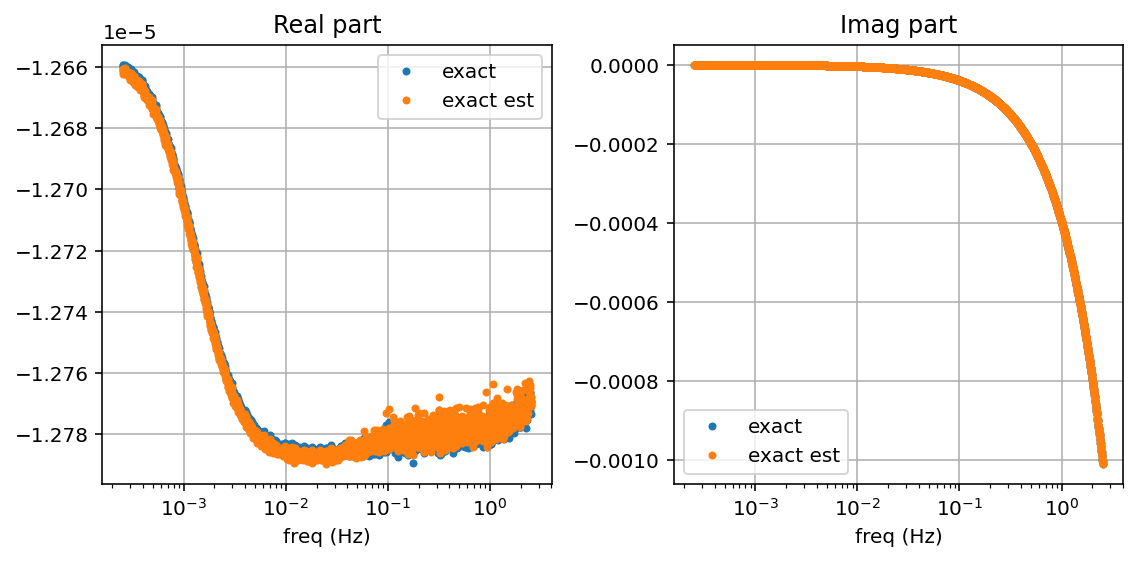

In [533]:
ws = np.geomspace(0.01, 1e2, 2000)/2/np.pi # 1 Hz to 10 kHz
etm = ElectrothermalSystem(M = 20, N = 40, syst_params = syst_params)

dpdi0 = np.zeros(ws.shape, dtype = np.cdouble) # exact
dpdi1 = np.zeros(ws.shape, dtype = np.cdouble) # approx with true Z0
dpdi2 = np.zeros(ws.shape, dtype = np.cdouble) # approx with approx Z0
dpdi3 = np.zeros(ws.shape, dtype = np.cdouble) # approx with imag(Z)

for i, w in tqdm.tqdm(enumerate(ws)):
    etm.generate_everything()

    Z, dpdi = etm.get_Z_dPdI(w)

    Rtes = etm.M*etm.Rmean
    R_tot = etm0.get_R_tot(w0)
    R_tot_est = Rtes*(2+etm0.Bmean)

    Z0 = etm.get_Z0(w)
    Z0_est = 1j*w*etm.L + etm.Rl + Rtes*(1 + etm.Bmean)

    dpdi0[i] = dpdi
    dpdi1[i] = -etm.I0*R_tot*Z/(Z - Z0)
    dpdi2[i] = -etm.I0*R_tot_est*Z/(Z-Z0_est)
    dpdi3[i] = etm.I0*R_tot*Z/np.imag(Z)


fig, axs = plot_traces(dpdi0, dpdi1, x = ws/2/np.pi, labels = ('exact', 'exact est', 'approx est'), figsize = (8,4), ls = '.')
for ax in axs:
    ax.grid()
    ax.legend()
    ax.semilogx()
    ax.set_xlabel('freq (Hz)')
    #ax.loglog()

fig.tight_layout()

Text(0.5, 0, 'freq (Hz)')

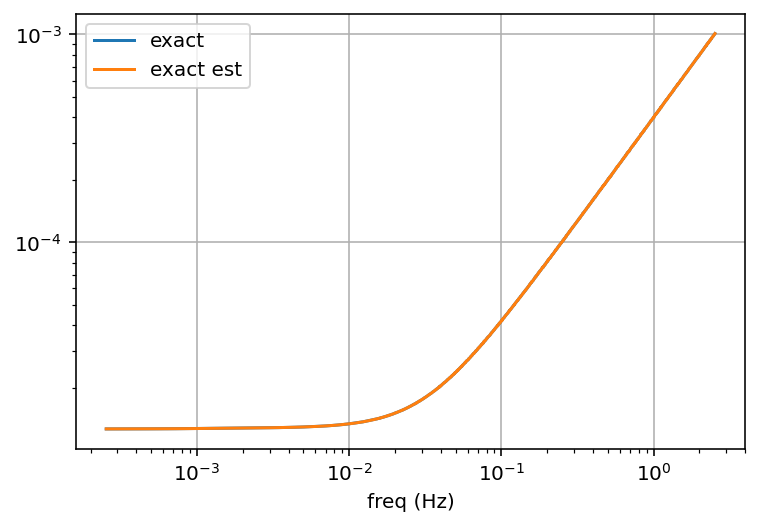

In [539]:
plt.figure()
plt.grid()


for dat, label in zip((dpdi0, dpdi1), ('exact', 'exact est', 'approx est')):
    plt.plot(ws/2/np.pi, abs(dat), '-', label = label)

plt.legend()
plt.loglog()
plt.xlabel('freq (Hz)')

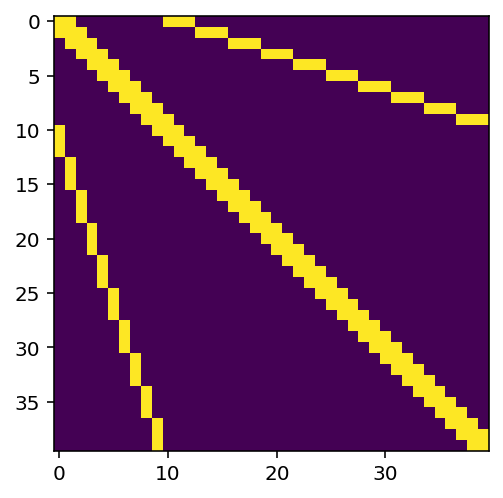

In [393]:
# nearest neighbor and distributed outer connections to TES components
M = 10
N = 30
i, j = np.meshgrid(np.arange(M+N), np.arange(M+N))
NEAREST_NEIGHBOR = (abs(i - j) < 2)
OUTER_CONNECTIONS = (i<M)*(j>=M)*((j-M)//(N//M) == i) + (j<M)*(i>=M)*((i-M)//(N//M) == j)
#plt.imshow(NEAREST_NEIGHBOR)
#plt.imshow(OUTER_CONNECTIONS)
plt.imshow((OUTER_CONNECTIONS+NEAREST_NEIGHBOR))

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:06<00:00, 32.12it/s]


Text(0.5, 0.98, 'dpdi')

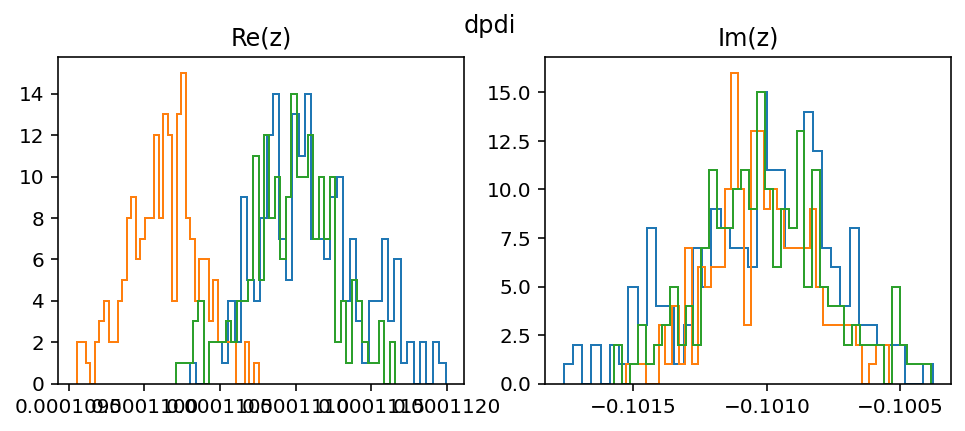

In [430]:
# distribution of R_avg/Rmean (real and imag) at 10 kHz for M = 300, N = 900
numrepeats = 200
M1 = 10
N1 = 20
w0 = 1e4/2/np.pi # 10 kHz
R_avg1 = np.zeros(numrepeats, dtype = np.cdouble)
R_avg2 = np.zeros(numrepeats, dtype = np.cdouble)
etm1 = ElectrothermalSystem(M1, N1, syst_params)
etm2 = ElectrothermalSystem(2*M1, 2*N2, syst_params)
etm3 = ElectrothermalSystem(15, 30, syst_params)
Zs = np.zeros((numrepeats, 3), dtype = np.cdouble)
dPdIs = np.zeros((numrepeats, 3), dtype = np.cdouble)


for i in tqdm.trange(numrepeats):
    R_avg1[i] = etm1.get_R_tot(w0, regen = True)
    R_avg2[i] = etm2.get_R_tot(w0, regen = True)
    etm3.generate_everything()
    Zs[i,0], dPdIs[i,0] = etm1.get_Z_dPdI(w0)
    Zs[i,1], dPdIs[i,1] = etm2.get_Z_dPdI(w0)
    Zs[i,2], dPdIs[i,2] = etm3.get_Z_dPdI(w0)

fig, axs = complex_histogram(dPdIs[:,0], figsize = (8,3))
axs[0].hist(np.real(dPdIs[:,1]), bins = 40, histtype = 'step')
axs[1].hist(np.imag(dPdIs[:,1]), bins = 40, histtype = 'step')
axs[0].hist(np.real(dPdIs[:,2]), bins = 40, histtype = 'step')
axs[1].hist(np.imag(dPdIs[:,2]), bins = 40, histtype = 'step')
fig.suptitle('dpdi')


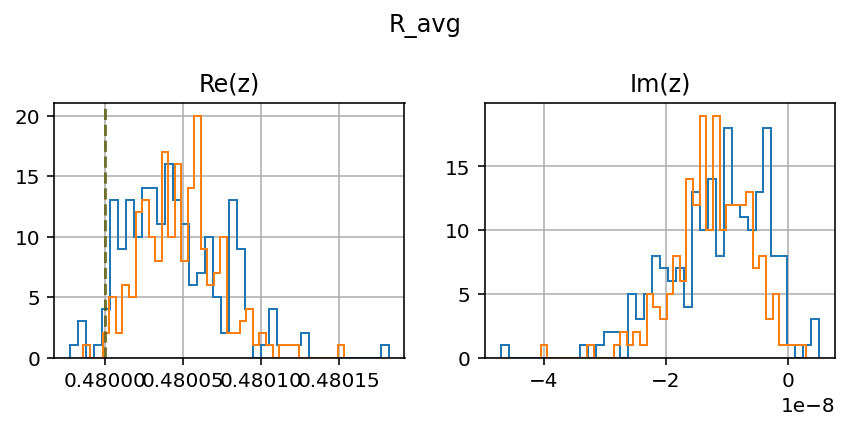

In [431]:
#np.savetxt('Ravg.dat', R_avg)
#R_avg2 = np.loadtxt('Ravg.dat', dtype = np.cdouble)
fig, axs = complex_histogram(R_avg1, figsize = (6,3))
axs[0].hist(np.real(R_avg2), histtype = 'step', bins = 40)
axs[1].hist(np.imag(R_avg2), histtype = 'step', bins = 40)
#fig.suptitle(f'R_avg at 1 kHz, M = {etm2.M}, N = {etm2.N}')
for ax in axs:
    ax.grid()
axs[0].axvline(etm1.M*etm1.Rmean*(2+etm1.Bmean), color = 'r', linestyle = 'dashed', alpha = 0.5)
axs[0].axvline(etm2.M*etm2.Rmean*(2+etm2.Bmean), color = 'g', linestyle = 'dashed', alpha = 0.5)
fig.suptitle('R_avg')
fig.tight_layout()

Text(0.5, 0.98, 'impedances')

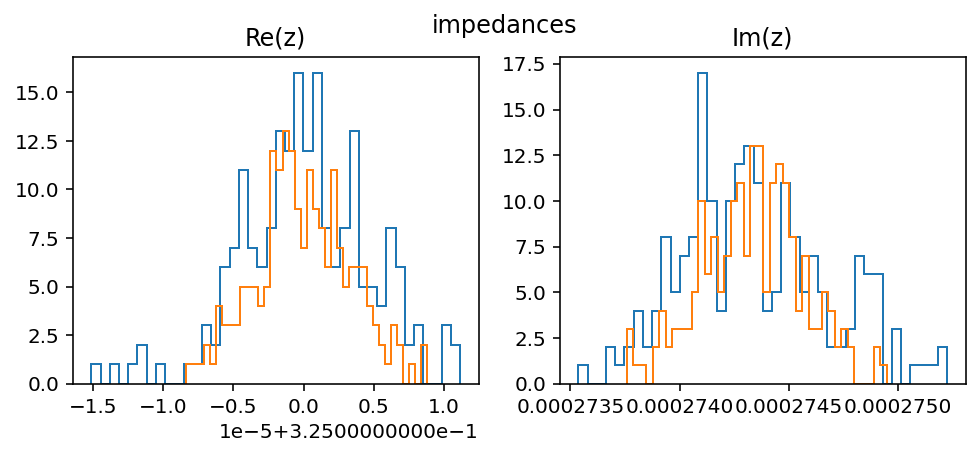

In [432]:
fig, axs = complex_histogram(Zs[:,0], figsize = (8,3))
axs[0].hist(np.real(Zs[:,1]), bins = 40, histtype = 'step')
axs[1].hist(np.imag(Zs[:,1]), bins = 40, histtype = 'step')
fig.suptitle('impedances')

Text(0.5, 0.98, 'dpdi')

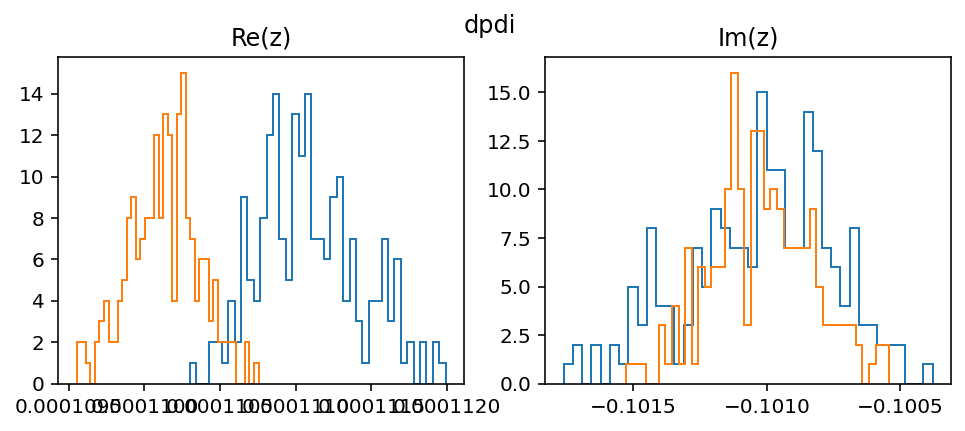

In [433]:
fig, axs = complex_histogram(dPdIs[:,0], figsize = (8,3))
axs[0].hist(np.real(dPdIs[:,1]), bins = 40, histtype = 'step')
axs[1].hist(np.imag(dPdIs[:,1]), bins = 40, histtype = 'step')
fig.suptitle('dpdi')

100%|██████████| 200/200 [00:00<00:00, 409.36it/s]


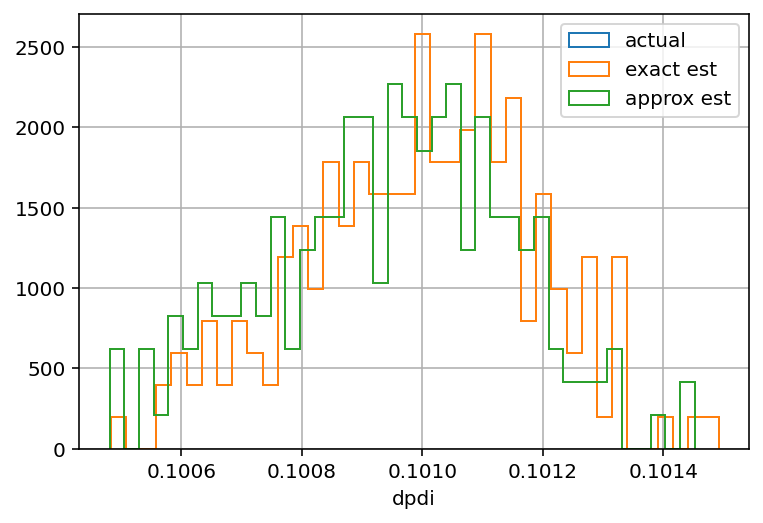

In [480]:
# distribution of R_avg/Rmean (real and imag) at 10 kHz for M = 300, N = 900
numrepeats = 200
w0 = 1e4/2/np.pi # 10 kHz

etm0 = ElectrothermalSystem(15, 15, syst_params)
Zs = np.zeros(numrepeats, dtype = np.cdouble)
dPdIs = np.zeros(numrepeats, dtype = np.cdouble)

Z0_est = np.zeros(numrepeats, dtype = np.cdouble)
Z1_est = np.zeros(numrepeats, dtype = np.cdouble)
Z2_est = np.zeros(numrepeats, dtype = np.cdouble)
dZ = np.zeros(numrepeats)

for i in tqdm.trange(numrepeats):

    # reroll random variables
    etm0.generate_everything()

    Z, dPdI = etm0.get_Z_dPdI(w0)

    dPdIs[i] = dPdI

    R_tot = etm0.get_R_tot(w0)

    Rtes = etm0.M*etm0.Rmean
    Z0 = 1j*w0*etm0.L + etm0.Rl + (etm0.R_m*(1+etm0.beta_m)).sum()#Rtes*(1 + etm0.Bmean)
    Z1 = 1j*w0*etm0.L + etm0.Rl + Rtes*(1 + etm0.Bmean)

    dZ[i] = (etm0.R_m*(1+etm0.beta_m)).sum() - Rtes*(1 + etm0.Bmean)

    Z0_est[i] = -etm0.I0*R_tot*Z/(Z - Z0)
    Z1_est[i] = -etm0.I0*Rtes*(2+etm0.Bmean)*Z/(Z - Z1)
    Z2_est[i] = etm0.I0*Rtes*(2+etm0.Bmean)*Z/np.imag(Z)

    
#MM = etm0.get_M(w0)

plt.figure()
plt.grid()

plt.xlabel('dpdi')


for dat, name in zip((dPdIs, Z0_est, Z1_est), ('actual', 'exact est', 'approx est')):
    plt.hist(abs(dat) + (dat is dPdIs)*0*0.00002, bins = 40, label = name, density = True, histtype = 'step')
plt.legend()

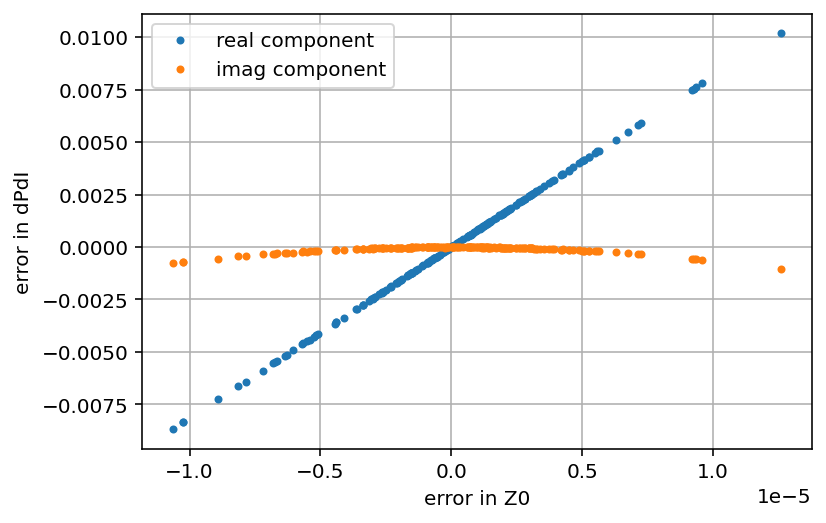

In [435]:
plt.figure()
plt.grid()
plt.plot(dZ, (np.real(Z0_est) - np.real(Z1_est)), '.', label = 'real component')
plt.plot(dZ, (np.imag(Z0_est) - np.imag(Z1_est)), '.', label = 'imag component')
plt.xlabel('error in Z0')
plt.ylabel('error in dPdI')
plt.legend()

(-0.009603844120566968,
 0.011111517141054128,
 -0.0010847376931963568,
 5.165417586649318e-05)

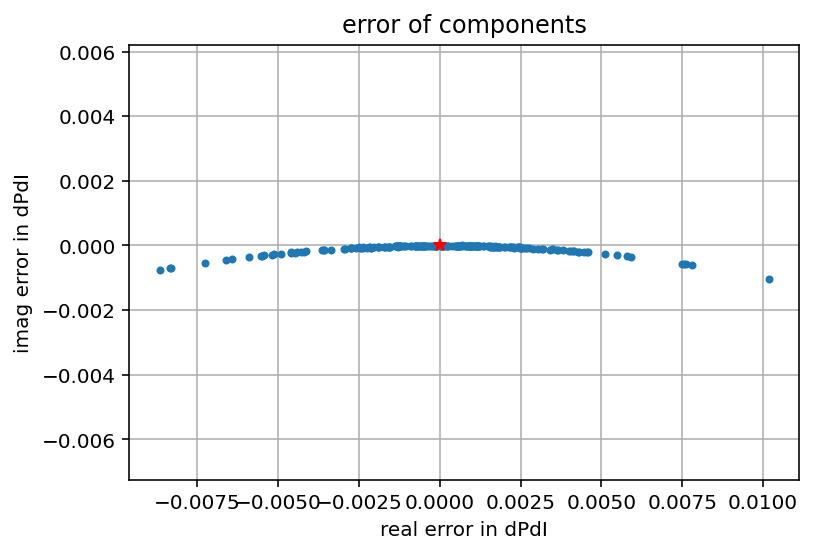

In [436]:
plt.figure()
plt.grid()
plt.title('error of components')
plt.plot((np.real(Z0_est) - np.real(Z1_est)), (np.imag(Z0_est) - np.imag(Z1_est)), '.')
plt.plot([0],[0], 'r*')
plt.xlabel('real error in dPdI')
plt.ylabel('imag error in dPdI')
plt.axis('equal')

Text(0, 0.5, 'Im(dPdI)')

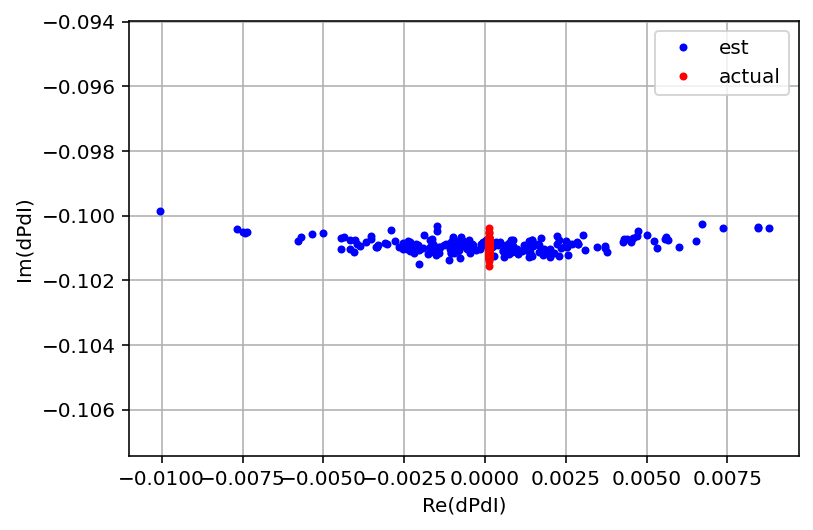

In [465]:
plt.figure()
plt.grid()
plt.axis('equal')
plt.plot(np.real(Z1_est), np.imag(Z1_est), 'b.', label = 'est')
plt.plot(np.real(Z0_est), np.imag(Z0_est), 'r.', label = 'actual')
plt.legend()
plt.xlabel('Re(dPdI)')
plt.ylabel('Im(dPdI)')

Text(0, 0.5, 'Im(dPdI)')

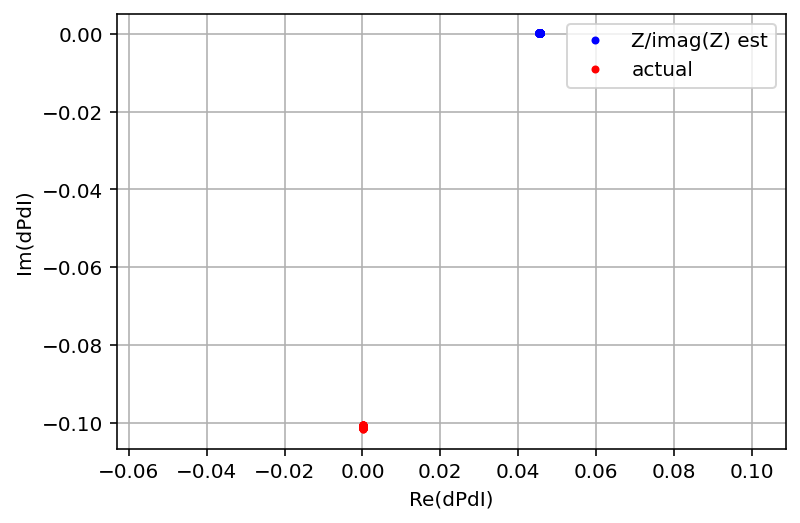

In [481]:
plt.figure()
plt.grid()
plt.axis('equal')
plt.plot(np.real(Z2_est), np.imag(Z2_est), 'b.', label = 'Z/imag(Z) est')
plt.plot(np.real(Z0_est), np.imag(Z0_est), 'r.', label = 'actual')
plt.legend()
plt.xlabel('Re(dPdI)')
plt.ylabel('Im(dPdI)')

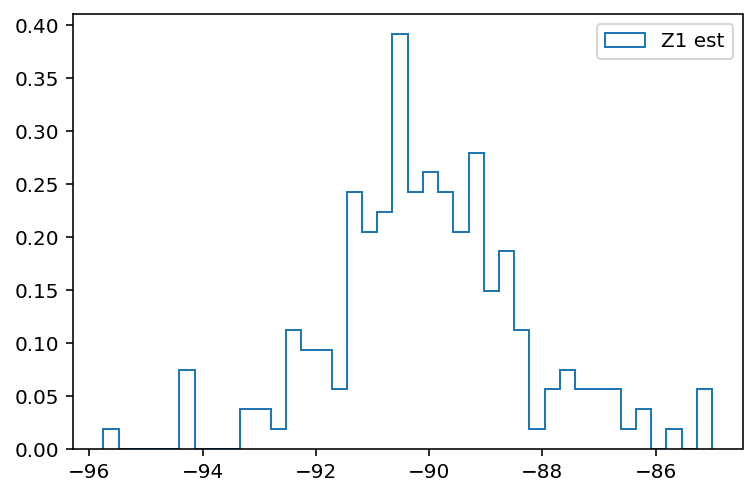

In [476]:
plt.figure()
#plt.hist(np.angle(Z0_est)*180/np.pi, bins = 40, density = True, histtype = 'step', label = 'exact')
plt.hist(np.angle(Z1_est)*180/np.pi, bins = 40, density = True, histtype = 'step', label = 'Z1 est')
plt.legend()
#plt.plot([0],[0])

Text(0, 0.5, 'Im(dPdI0-dPdI1)')

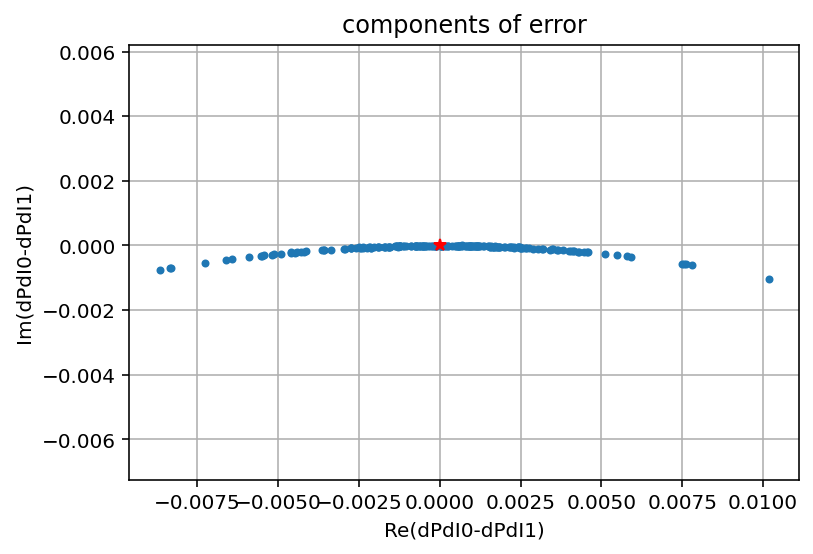

In [438]:
plt.figure()
plt.grid()
plt.title('components of error')
plt.plot(np.real(Z0_est-Z1_est), np.imag(Z0_est-Z1_est), '.')
plt.plot([0],[0], 'r*')
plt.axis('equal')
plt.xlabel('Re(dPdI0-dPdI1)')
plt.ylabel('Im(dPdI0-dPdI1)')

In [439]:
w0 = 1e3/2/np.pi
etm0 = ElectrothermalSystem(15, 15, syst_params)
Z, dPdI = etm0.get_Z_dPdI(w0)
#MM = etm0.get_M(w0)
R_tot = etm0.get_R_tot(w0)
Rtes = etm0.M*etm0.Rmean
Z0 = 1j*w0*etm0.L + etm0.Rl + (etm0.R_m*(1+etm0.beta_m)).sum()#Rtes*(1 + etm0.Bmean)
Z1 = 1j*w0*etm0.L + etm0.Rl + Rtes*(1 + etm0.Bmean)
dPdI, -etm0.I0*R_tot*Z/(Z - Z0)

((-1.1356620119589579e-05-0.010100962854802126j),
 (-1.1356620119126053e-05-0.010100962854802132j))

In [440]:
Z0, Z1 # Z1 not sufficiently good approximation of Z0 to use though

((0.32500178996513457+3.978873577297384e-05j), (0.325+3.978873577297384e-05j))

In [441]:
dPdI, -etm0.I0*R_tot*Z/(Z - Z0), -etm0.I0*R_tot*Z/(Z - Z1)

((-1.1356620119589579e-05-0.010100962854802126j),
 (-1.1356620119126053e-05-0.010100962854802132j),
 (-2.598842279544924e-05-0.0101009626039149j))

In [442]:
abs(dPdI), abs(-etm0.I0*R_tot*Z/(Z - Z0)), abs(-etm0.I0*R_tot*Z/(Z - Z1))

(0.010100969238984587, 0.010100969238984592, 0.010100996036223688)

In [443]:
Z/(Z-Z0), Z/(Z-Z1)

((0.2956191506625834+263.01060599984993j),
 (0.6766045421235144+263.0105995924686j))

In [444]:
Rtes*(1 + etm0.Bmean), (etm0.R_m*(1+etm0.beta_m)).sum()

(0.32, 0.32000178996513456)

In [445]:
R_tot - Rtes*(2+etm0.Bmean)

(6.44264960137364e-05-1.5783950934624294e-07j)

In [446]:
etm0.Rl

0.005

In [447]:
Z-Z0

(-3.158076478826377e-06-0.0012356899610228174j)

In [448]:
small_syst = ElectrothermalSystem(2,3, syst_params)

np.real(small_syst.base_coefficient_mtx)

array([[ 1.30001453e+06,  1.04640633e+05,  1.00977663e+05,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.87125572e+00, -4.18323021e-01, -1.97321212e-04,
        -1.96984629e-04, -0.00000000e+00, -0.00000000e+00],
       [-3.80885558e+00, -2.00464221e-04, -4.02763577e-01,
        -1.99238677e-04, -2.02418070e-04, -0.00000000e+00],
       [ 0.00000000e+00, -3.04520934e-04, -2.99069244e-04,
         1.21026731e-03, -3.03512960e-04, -0.00000000e+00],
       [ 0.00000000e+00, -0.00000000e+00, -3.03045213e-04,
        -2.99287658e-04,  1.19661853e-03, -2.96408267e-04],
       [ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -3.02958525e-04,  6.04531606e-04]])

In [449]:

M = 100 # number of TES component heat capacities
N = 200 # number of external heat capacities


etm = ElectrothermalSystem(M, N, syst_params)

print(abs(etm.get_R_tot(1e3))/(etm.M*etm.Rmean*(2+etm.Bmean)))

1.0001121144989142


In [450]:
w = 1e3
MM = etm.get_M(w)
zm, logdms = etm.get_logdm(w)
z0, logd0 = np.linalg.slogdet(MM)

(MM[:M+1,0]*(zm/z0)*np.exp(logdms-logd0)).sum() # should be one

(1.0000000000002516-9.128982292327947e-17j)

In [451]:
k, z = small_syst.get_logdm(10)

In [452]:
vec, logdm = etm.get_logdm(1e1)
logd0 = logdm[0] # first entry (diagonal entry corresponding to M_{0,0})
dm = (vec/vec[0])*np.exp(logdm - logd0)
dmx = np.real(dm[1:])
dmy = np.imag(dm[1:])

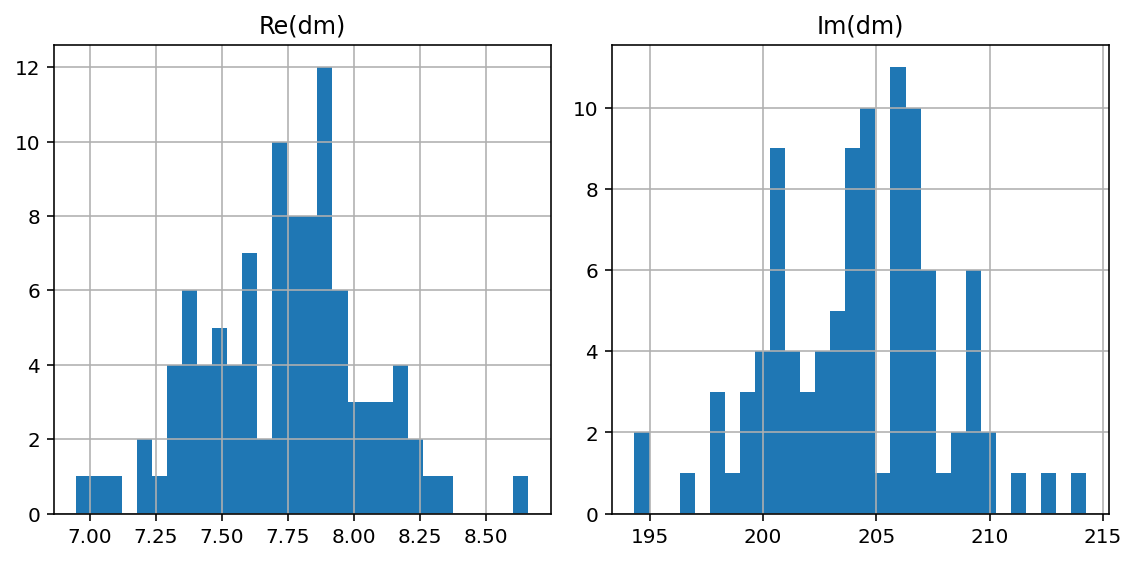

In [453]:

fig, axs  = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
axs[0].hist(dmx, bins = 30)
axs[0].set_title('Re(dm)')
axs[1].hist(dmy, bins = 30)
axs[1].set_title('Im(dm)')

for ax in axs:
    ax.grid()

fig.tight_layout()

In [454]:
vec[:4], logdm[:4]

(array([-0.40781038+0.91306664j, -0.9280352 -0.37249251j,
        -0.9283719 -0.37165254j, -0.92771447-0.37329059j]),
 array([690.84768065+0.j, 696.17981364+0.j, 696.18893021+0.j,
        696.15296714+0.j]))

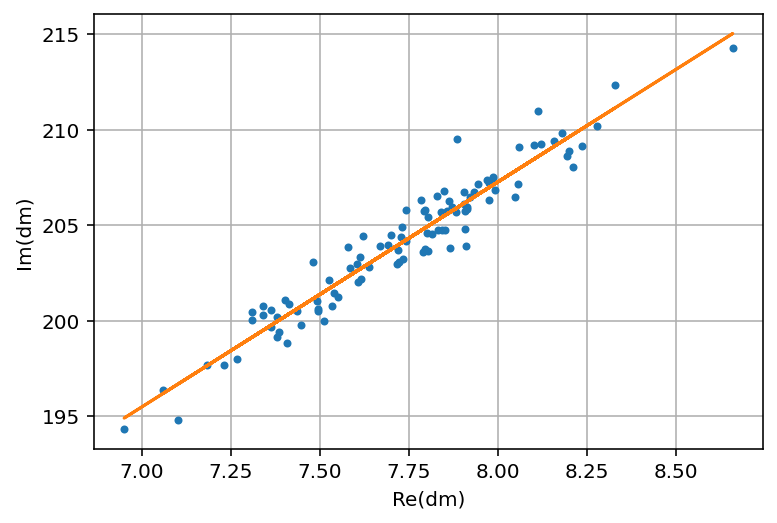

In [455]:
plt.figure()
plt.grid()
plt.xlabel('Re(dm)')
plt.ylabel('Im(dm)')
plt.plot(dmx, dmy, '.')
dm_fit = ss.linregress(x = dmx, y = dmy)
dml = dmx*dm_fit.slope + dm_fit.intercept
plt.plot(dmx, dml)

In [456]:
dm_fit

LinregressResult(slope=11.776732934439703, intercept=113.0440338354664, rvalue=0.9639825458320642, pvalue=3.578501151414414e-58, stderr=0.32822218793831215, intercept_stderr=2.5421039481648537)

Text(0.5, 0, 'vertical residual from linear fit')

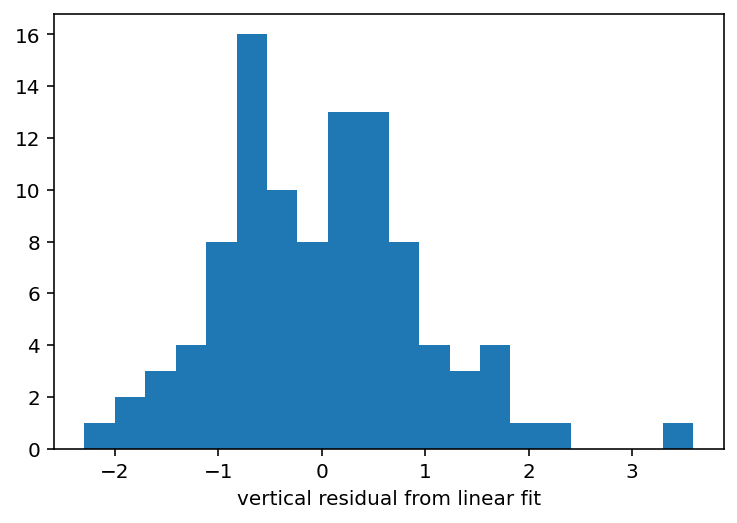

In [457]:
plt.hist(dmy - dml, bins = 20)
plt.xlabel('vertical residual from linear fit')

In [458]:
ws = np.geomspace(0.01, 1e6, 50)

ratios = np.array([abs(etm2.get_R_tot(w))/(etm.M*etm.Rmean*(2+etm.Bmean)) for w in ws])

Text(0, 0.5, 'R_avg/Rmean')

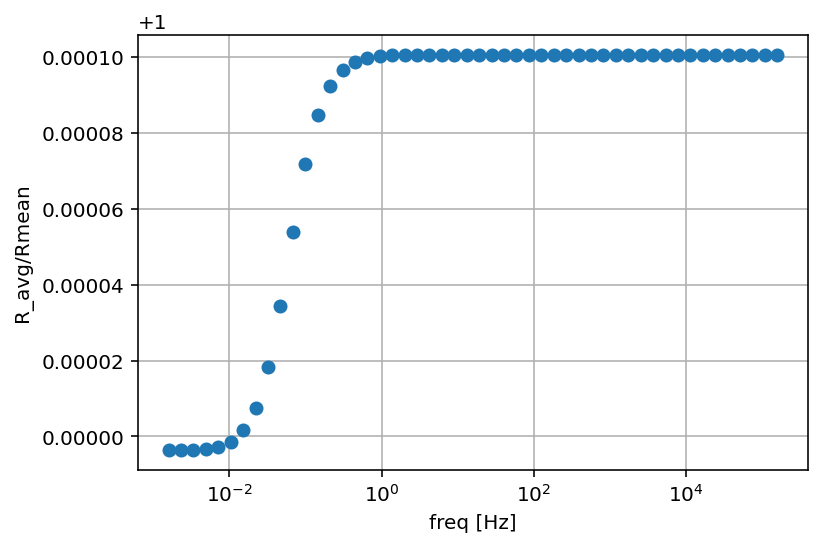

In [459]:
plt.figure()
plt.semilogx()
plt.plot(ws/2/np.pi, ratios, 'o')
plt.grid()
plt.xlabel('freq [Hz]')
plt.ylabel('R_avg/Rmean')

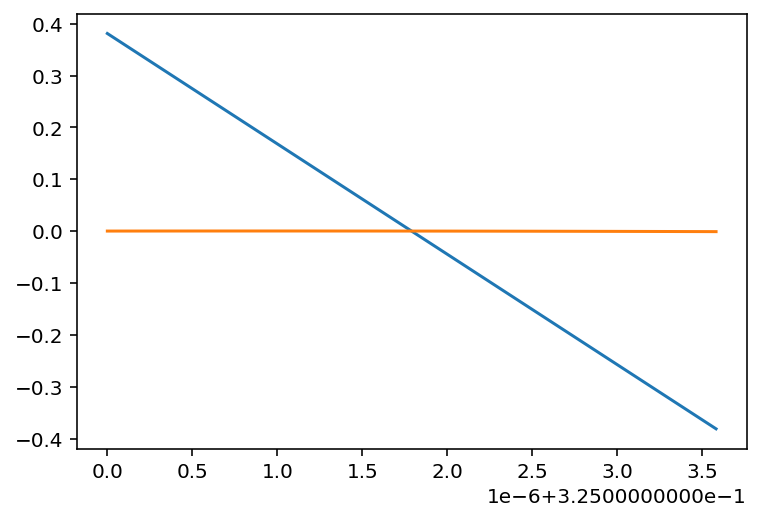

In [464]:

xs = Z0 + (Z1-Z0)*np.linspace(-1, 1, 100)
ys = Z/(Z-xs)

ys -= ys.mean()

plt.plot(np.real(xs), np.real(ys))
plt.plot(np.real(xs), np.imag(ys))
